[Reference](https://thepythonlab.medium.com/building-a-backtesting-system-in-python-with-object-oriented-programming-2ae6677f90fe)

In [1]:
pip install yfinance

# Loading Historical Data

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

# Backtesting Class
class BacktestingSystem:
    def __init__(self, initial_cash=100):
        self.data = None
        self.initial_cash = initial_cash

    # Download data from yfinance
    def load_data(self, symbol, start_date, end_date):
        ticker = yf.Ticker(symbol)
        df = ticker.history(start=start_date, end=end_date)
        self.data = df[['Open', 'High', 'Low', 'Close', 'Volume']]
        self.data.columns = ['open', 'high', 'low', 'close', 'volume']

    # Visualize Results
    def plot_results(self, portfolio):
        plt.style.use('seaborn-whitegrid')

        fig, ax = plt.subplots(2, 1, figsize=(12, 8))

        # Plot stock price
        ax[0].plot(self.data['close'], label='Price', color='steelblue', linewidth=2)
        ax[0].set_ylabel('Price', fontsize=12)
        ax[0].legend(loc='upper left', fontsize=10)

        # Plot portfolio value
        ax[1].plot(portfolio['total'], label='Portfolio Value', color='forestgreen', linewidth=2)
        ax[1].set_ylabel('Portfolio Value', fontsize=12)
        ax[1].legend(loc='upper left', fontsize=10)

        # Set x-axis label for the last subplot
        ax[1].set_xlabel('Date', fontsize=12)

        # Adjust spacing between subplots
        plt.tight_layout(pad=2)

        # Set title and axis labels
        fig.suptitle('Backtesting Results', fontsize=16, fontweight='bold')

        # Customize tick parameters
        plt.tick_params(axis='both', which='both', bottom=False, left=False)

        # Remove spines
        for axis in ['top', 'right']:
            ax[0].spines[axis].set_visible(False)
            ax[1].spines[axis].set_visible(False)

        # Display the plot
        plt.show()

    # Backtest strategy
    def backtest_strategy(self, strategy):
        signals = strategy.generate_signals()
        positions = signals['signal'].diff()
        portfolio = pd.DataFrame(index=self.data.index)
        portfolio['position'] = positions
        portfolio['close'] = self.data['close']
        # Calculate portfolio value
        portfolio['holdings'] = portfolio['position'].cumsum() * portfolio['close']
        portfolio['cash'] = self.initial_cash - (portfolio['position'] * portfolio['close']).cumsum()
        portfolio['total'] = portfolio['cash'] + portfolio['holdings']
        # Calculate portfolio returns
        portfolio['returns'] = portfolio['total'].pct_change()
        return portfolio

# Backtest Moving Average Strategy

In [3]:
# Moving Average Crossover Strategy
class MovingAverageCrossoverStrategy:
    def __init__(self, data, short_window, long_window):
        self.data = data
        self.short_window = short_window
        self.long_window = long_window

    def generate_signals(self):
        signals = pd.DataFrame(index=self.data.index)
        signals['signal'] = 0

        # Calculate moving averages
        signals['short_mavg'] = self.data['close'].rolling(window=self.short_window, min_periods=1).mean()
        signals['long_mavg'] = self.data['close'].rolling(window=self.long_window, min_periods=1).mean()

        # Generate trading signals
        signals['signal'][self.short_window:] = \
            np.where(signals['short_mavg'][self.short_window:] > signals['long_mavg'][self.short_window:], 1, 0)

        return signals

<ipython-input-3-4c5df8754826>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signals['signal'][self.short_window:] = \
<ipython-input-2-b7f935196446>:21: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


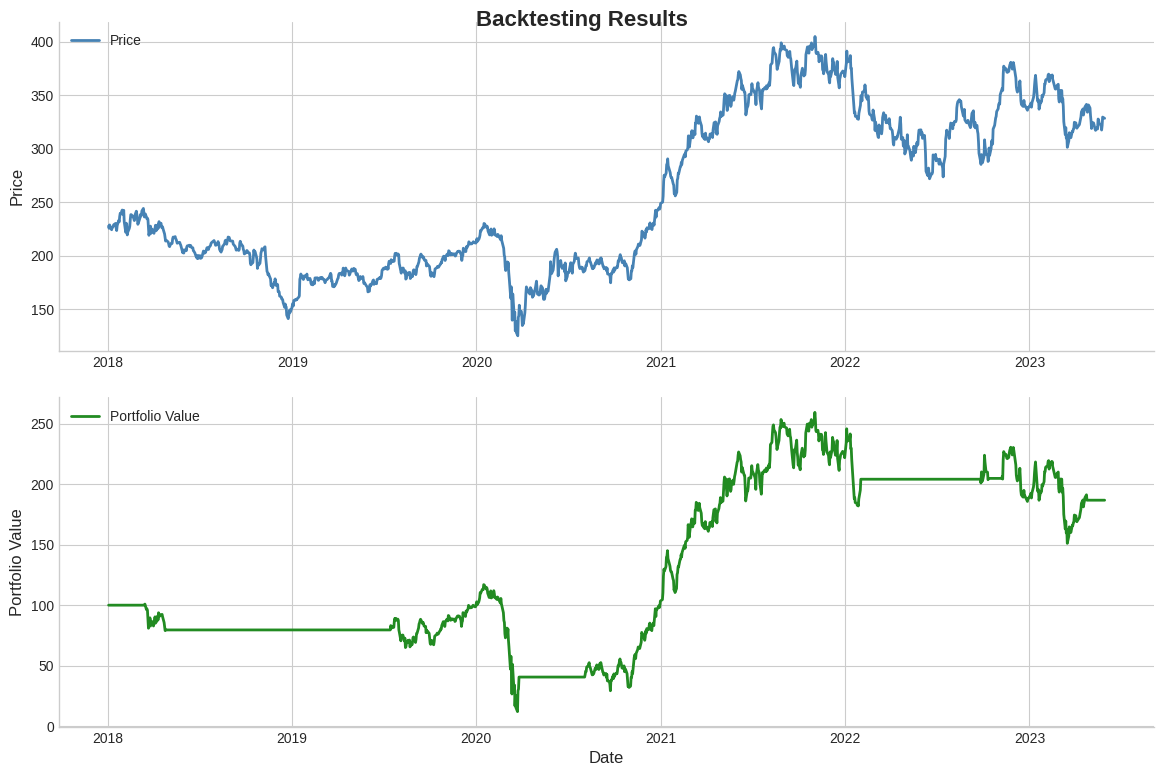

In [4]:
# Initiate Backtesting and Load Data
backtester = BacktestingSystem()
backtester.load_data('GS', '2018-01-01', '2023-05-31')

# Usage Example for Moving Average strategy
short_window = 50
long_window = 200
moving_average_strategy = MovingAverageCrossoverStrategy(backtester.data, short_window, long_window)
moving_average_portfolio = backtester.backtest_strategy(moving_average_strategy)
backtester.plot_results(moving_average_portfolio)

In [5]:
# Mean Reversion Strategy
class MeanReversionStrategy:
    def __init__(self, data, window, threshold):
        self.data = data
        self.window = window
        self.threshold = threshold

    def generate_signals(self):
        signals = pd.DataFrame(index=self.data.index)
        signals['signal'] = 0

        # Calculate mean and standard deviation
        signals['mean'] = self.data['close'].rolling(window=self.window, min_periods=1).mean()
        signals['std'] = self.data['close'].rolling(window=self.window, min_periods=1).std()

        # Generate trading signals
        signals['signal'][self.window:] = \
            np.where((self.data['close'][self.window:] - signals['mean'][self.window:]) > self.threshold, -1, 1)

        return signals

<ipython-input-5-b1ecfef7a292>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signals['signal'][self.window:] = \
<ipython-input-2-b7f935196446>:21: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


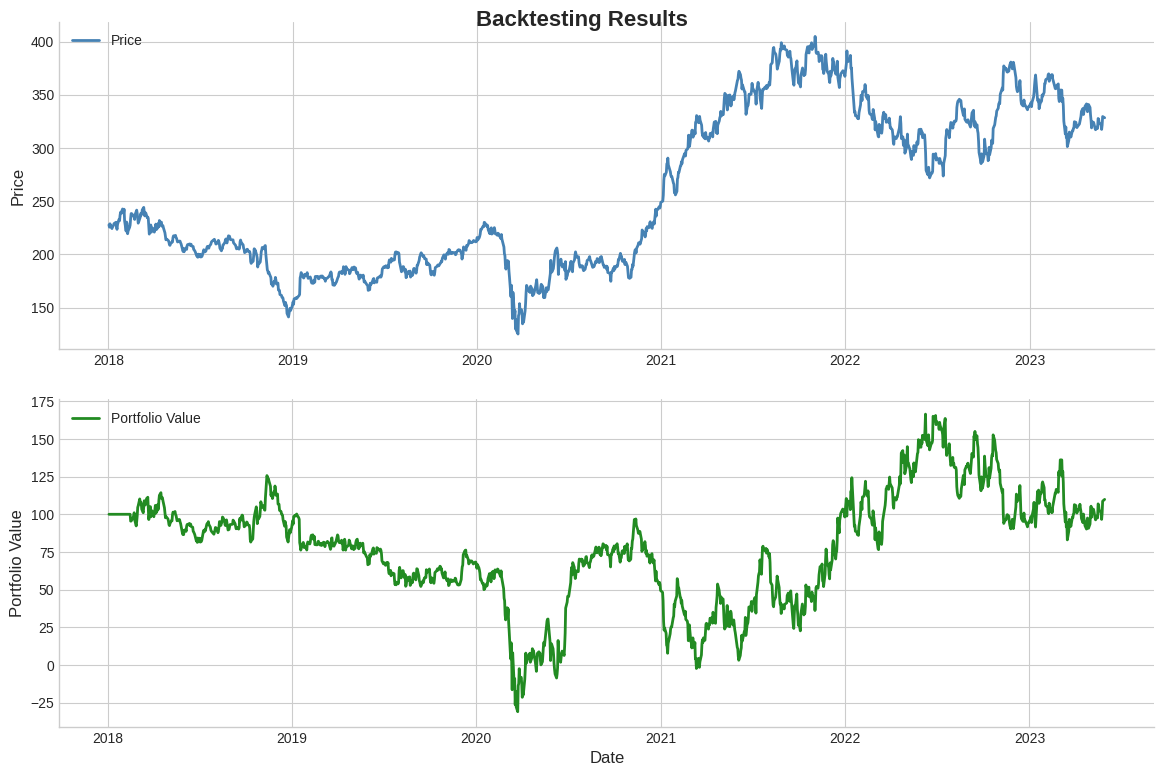

In [6]:
# Usage Example for Mean Reversion strategy
mean_reversion_window = 30
mean_reversion_threshold = 0.05

mean_reversion_strategy = MeanReversionStrategy(backtester.data, mean_reversion_window, mean_reversion_threshold)
mean_reversion_portfolio = backtester.backtest_strategy(mean_reversion_strategy)
backtester.plot_results(mean_reversion_portfolio)